## 📥 Dataset civil_comments – zmenšený multilabel sampling
Tento blok vytvorí zmenšený, stratifikovaný multilabel dataset so všetkými triedami.

In [ ]:
# 🔥 Úplné odstránenie nekompatibilných verzií
!pip uninstall -y transformers huggingface-hub tokenizers sentence-transformers peft

# 🧹 (ak máš oprávnenie) Vyčistenie cache
!rm -rf /root/.cache/huggingface

# ✅ Inštalácia stabilných verzií, ktoré sú 100 % kompatibilné s Trainer
!pip install transformers==4.40.1 huggingface-hub==0.30.2 tokenizers==0.19.1


In [ ]:

!pip install -q datasets pandas scikit-learn numpy tqdm

from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

# 📥 Načítanie datasetu
print("📥 Načítavam dataset 'civil_comments'...")
dataset = load_dataset("civil_comments")

# 📌 Upravené štítky bez severe_toxicity
label_columns = ["toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]
df_train = pd.DataFrame(dataset["train"])[["text"] + label_columns]
df_test = pd.DataFrame(dataset["test"])[["text"] + label_columns]

# 🔄 Binarizácia: >= 0.5 → 1
df_train[label_columns] = (df_train[label_columns] >= 0.5).astype(int)
df_test[label_columns] = (df_test[label_columns] >= 0.5).astype(int)

# 🧠 Sampling funkcia s progress barom
def balanced_subset(df, label_cols, min_per_label):
    samples = []
    for col in tqdm(label_cols, desc="⏳ Sampling podľa štítkov"):
        n = min(min_per_label, df[col].sum())
        samples.append(df[df[col] == 1].sample(n=n, random_state=42))
    combined = pd.concat(samples).drop_duplicates().sample(frac=1, random_state=42)
    return combined

# 🧪 Výber zmenšených množín
train_small = balanced_subset(df_train, label_columns, 3000)
test_valid_pool = balanced_subset(df_test, label_columns, 500)
valid_small = test_valid_pool.sample(frac=0.5, random_state=42)
test_small = test_valid_pool.drop(index=valid_small.index)

# ✅ Previesť všetky labely na float32
for df in [train_small, valid_small, test_small]:
    df[label_columns] = df[label_columns].astype("float32")

# 💾 Uloženie CSV
train_small.to_csv("train_multilabel_small.csv", index=False)
valid_small.to_csv("valid_multilabel_small.csv", index=False)
test_small.to_csv("test_multilabel_small.csv", index=False)

print(f"✅ Tréningový dataset: {len(train_small)} komentárov")
print(f"✅ Validačný dataset: {len(valid_small)} komentárov")
print(f"✅ Testovací dataset: {len(test_small)} komentárov")
print("\n📊 Distribúcia trénovacích dát:")
print(train_small[label_columns].sum())
print("\n📊 Distribúcia validačných dát:")
print(valid_small[label_columns].sum())
print("\n📊 Distribúcia testovacích dát:")
print(test_small[label_columns].sum())


In [1]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
# import evaluate  # Removed (not used, sklearn used instead)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


2025-05-12 07:31:43.515978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747035103.699457      91 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747035103.752403      91 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [5]:

from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer

# ✅ Načítanie CSV a konverzia na Dataset
train_df = pd.read_csv("/kaggle/input/miltilabel/train_multilabel_small(1).csv")
val_df = pd.read_csv("/kaggle/input/miltilabel/valid_multilabel_small.csv")
test_df = pd.read_csv("/kaggle/input/miltilabel/test_multilabel_small(1).csv")

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

# 🔢 Tokenizácia
checkpoint = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

# 🎯 Nastavenie dát pre Trainer
label_columns = ['toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask'] + label_columns)
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask'] + label_columns)
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask'] + label_columns)

# 🧷 Vytvorenie 'labels' z viacerých štítkov
def add_labels(example):
    example["labels"] = [example[col] for col in label_columns]
    return example

train_ds = train_ds.map(add_labels)
val_ds = val_ds.map(add_labels)
test_ds = test_ds.map(add_labels)

# Nastavenie výstupných stĺpcov
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/17190 [00:00<?, ? examples/s]

Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

Map:   0%|          | 0/17190 [00:00<?, ? examples/s]

Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

Map:   0%|          | 0/1107 [00:00<?, ? examples/s]

In [6]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
# import evaluate  # Removed (not used, sklearn used instead)
import numpy as np
import torch

# ✅ Definuj labely
label_columns = ["toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]

# ✅ Nastavenie checkpointu
checkpoint = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# ✅ Konfigurácia pre multilabel klasifikáciu
config = AutoConfig.from_pretrained(checkpoint)
config.num_labels = len(label_columns)
config.problem_type = "multi_label_classification"

# ✅ Model
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    config=config,
    ignore_mismatched_sizes=True
).to(device)

# ✅ Metriky pre multilabel (F1 a accuracy s prahom 0.5)
from sklearn.metrics import accuracy_score, f1_score

# ✅ Metriky pre multilabel klasifikáciu
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)

    return {
        "accuracy_micro": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_micro": f1_score(labels, preds, average="micro")
    }


# ✅ Tréningové argumenty
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    learning_rate=1e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
    report_to="none"
)

# ✅ Tréner
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ✅ Tréning
train_result = trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy Micro,F1 Macro,F1 Micro
1,0.264000,0.174979,0.676603,0.879571,0.912763
2,0.161800,0.167637,0.682927,0.881950,0.915425
3,0.137800,0.174362,0.686540,0.879535,0.914906
4,0.121000,0.172417,0.700994,0.884374,0.918438
5,0.110400,0.177422,0.693767,0.883134,0.916785


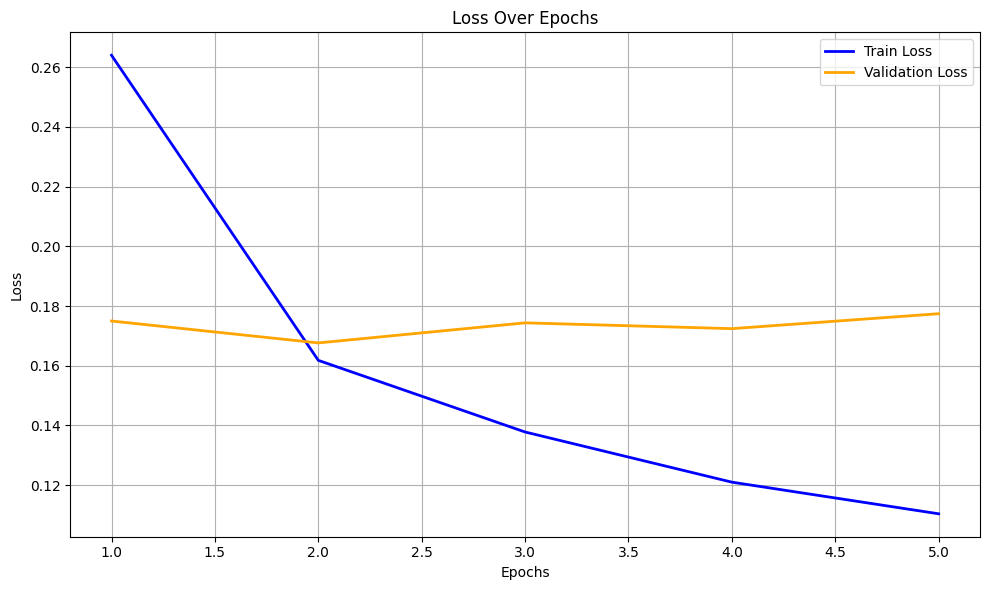

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

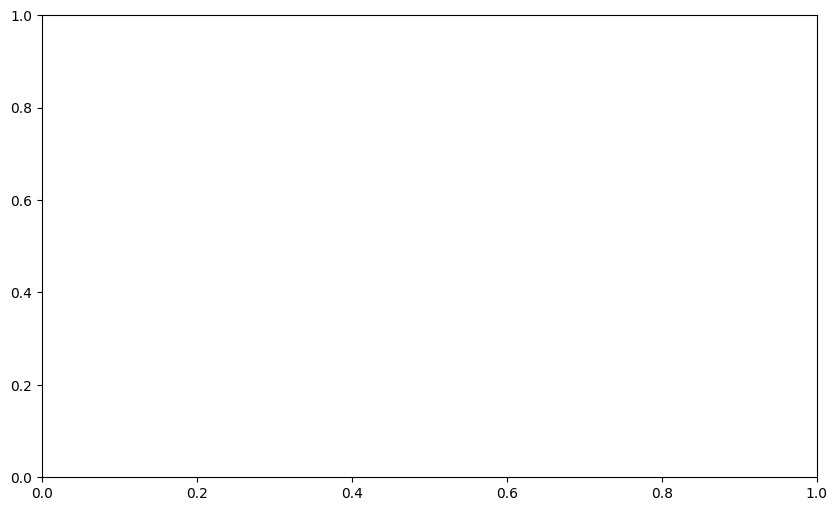

In [21]:

# 📊 Upravené grafy pre Loss a Accuracy po epochách

epoch_logs = [x for x in trainer.state.log_history if "epoch" in x and "eval_loss" in x]

train_loss_epoch = [x["loss"] for x in trainer.state.log_history if "loss" in x and "epoch" in x]
val_loss_epoch = [x["eval_loss"] for x in epoch_logs]
f1_micro_epoch = [x["eval_f1_micro"] for x in epoch_logs if "eval_f1_micro" in x]
acc_epoch = [x["eval_accuracy"] for x in epoch_logs if "eval_accuracy" in x]


epochs = [x["epoch"] for x in epoch_logs]

# Loss graf
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label="Train Loss", color="blue", linewidth=2)
plt.plot(epochs, val_loss_epoch, label="Validation Loss", color="orange", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"/kaggle/working/results/loss_clean_graph.png", dpi=300)

plt.show()

# Accuracy graf
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_epoch, label="Validation Accuracy", marker='s', color="green", linewidth=2)
plt.plot(epochs, val_loss_epoch, label="Validation Loss", color="orange", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"/kaggle/working/results/accuracy_graph.png", dpi=300)
plt.show()


In [10]:

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, matthews_corrcoef, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import os

# ✅ Výstupný priečinok
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

# ✅ Predikcie na testovacej množine
preds_output = trainer.predict(test_ds)
logits = torch.tensor(preds_output.predictions)
probs = torch.sigmoid(logits).numpy()
labels = preds_output.label_ids
final_preds = (probs >= 0.5).astype(int)

# ✅ Zoznam štítkov (musí byť definovaný skôr v kóde)
# label_columns = ["toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]

# 📄 Classification Report
report = classification_report(labels, final_preds, target_names=label_columns, digits=4, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f"{output_dir}/classification_report_multilabel.csv")
print(pd.DataFrame(report).transpose())

# 📌 MCC – priemerný cez všetky štítky
mcc_scores = [matthews_corrcoef(labels[:, i], final_preds[:, i]) for i in range(len(label_columns))]
for label, mcc in zip(label_columns, mcc_scores):
    print(f"MCC for {label}: {mcc:.4f}")

# 📊 Confusion matrix pre každý štítok
for i, label in enumerate(label_columns):
    cm = confusion_matrix(labels[:, i], final_preds[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-toxic", "Toxic"],
                yticklabels=["Non-toxic", "Toxic"])
    plt.title(f"Confusion Matrix – {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/confusion_matrix_{label}.png", dpi=300)
    plt.close()

# 📈 ROC & PR krivky pre každý štítok
for i, label in enumerate(label_columns):
    fpr, tpr, _ = roc_curve(labels[:, i], probs[:, i])
    precision, recall, _ = precision_recall_curve(labels[:, i], probs[:, i])
    roc_auc = roc_auc_score(labels[:, i], probs[:, i])
    pr_auc = auc(recall, precision)

    # ROC curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/roc_curve_{label}.png", dpi=300)
    plt.close()

    # PR curve
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}", color="blue")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pr_curve_{label}.png", dpi=300)
    plt.close()

                 precision    recall  f1-score  support
toxicity          0.953804  0.997159  0.975000   1056.0
obscene           0.858209  0.920000  0.888031    250.0
threat            0.833333  0.913978  0.871795     93.0
insult            0.868671  0.868671  0.868671    632.0
identity_attack   0.867159  0.883459  0.875233    266.0
sexual_explicit   0.677019  0.893443  0.770318    122.0
micro avg         0.890859  0.934684  0.912245   2419.0
macro avg         0.843032  0.912785  0.874841   2419.0
weighted avg      0.893564  0.934684  0.912970   2419.0
samples avg       0.903162  0.945047  0.909732   2419.0
MCC for toxicity: -0.0115
MCC for obscene: 0.8548
MCC for threat: 0.8605
MCC for insult: 0.6939
MCC for identity_attack: 0.8353
MCC for sexual_explicit: 0.7467


In [25]:
import zipfile
import os

# Názov výstupného ZIP súboru
zip_filename = "model_visualizations.zip"
output_dir = "./results"

# Vytvorenie ZIP archívu
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                zipf.write(file_path, arcname=os.path.relpath(file_path, output_dir))

print(f"✅ Všetky PNG súbory boli zabalené do {zip_filename}")


✅ Všetky PNG súbory boli zabalené do model_visualizations.zip


In [11]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Výpočet mikro, makro a weighted metrík
f1_micro = f1_score(labels, final_preds, average='micro')
f1_macro = f1_score(labels, final_preds, average='macro')
f1_weighted = f1_score(labels, final_preds, average='weighted')

precision_micro = precision_score(labels, final_preds, average='micro')
precision_macro = precision_score(labels, final_preds, average='macro')
precision_weighted = precision_score(labels, final_preds, average='weighted')

recall_micro = recall_score(labels, final_preds, average='micro')
recall_macro = recall_score(labels, final_preds, average='macro')
recall_weighted = recall_score(labels, final_preds, average='weighted')

print(f"F1 micro: {f1_micro:.4f}")
print(f"F1 macro: {f1_macro:.4f}")
print(f"F1 weighted: {f1_weighted:.4f}")
print(f"Precision micro: {precision_micro:.4f}")
print(f"Precision macro: {precision_macro:.4f}")
print(f"Precision weighted: {precision_weighted:.4f}")
print(f"Recall micro: {recall_micro:.4f}")
print(f"Recall macro: {recall_macro:.4f}")
print(f"Recall weighted: {recall_weighted:.4f}")

# Uloženie do CSV pre bakalársku prácu
import pandas as pd
metrics_summary = pd.DataFrame({
    "F1": [f1_micro, f1_macro, f1_weighted],
    "Precision": [precision_micro, precision_macro, precision_weighted],
    "Recall": [recall_micro, recall_macro, recall_weighted]
}, index=["micro", "macro", "weighted"])

metrics_summary.to_csv(f"{output_dir}/micro_macro_metrics.csv", float_format="%.4f")
metrics_summary


F1 micro: 0.9122
F1 macro: 0.8748
F1 weighted: 0.9130
Precision micro: 0.8909
Precision macro: 0.8430
Precision weighted: 0.8936
Recall micro: 0.9347
Recall macro: 0.9128
Recall weighted: 0.9347


,F1,Precision,Recall
micro,0.912245,0.890859,0.934684
macro,0.874841,0.843032,0.912785
weighted,0.912970,0.893564,0.934684


In [12]:
# 📊 Získanie predikcií na testovacej množine
preds_output = trainer.predict(test_ds)
labels = preds_output.label_ids
probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()
preds = (probs > 0.5).astype(int)

# 🏷️ Definícia názvov štítkov (labelov)
label_cols = ["toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]

# 📈 Výpočet MCC, ROC AUC a PR AUC pre každú triedu
from sklearn.metrics import matthews_corrcoef, roc_auc_score, precision_recall_curve, auc

print("🔎 Metriky pre každú triedu:")
print("-" * 60)
for i, label in enumerate(label_cols):
    mcc = matthews_corrcoef(labels[:, i], preds[:, i])
    try:
        roc_auc = roc_auc_score(labels[:, i], probs[:, i])
    except:
        roc_auc = float('nan')
    precision, recall, _ = precision_recall_curve(labels[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    print(f"{label:20} | MCC: {mcc:.4f} | ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")


🔎 Metriky pre každú triedu:
------------------------------------------------------------
toxicity             | MCC: 0.1176 | ROC AUC: 0.6907 | PR AUC: 0.9692
obscene              | MCC: 0.3942 | ROC AUC: 0.9748 | PR AUC: 0.9245
threat               | MCC: 0.8176 | ROC AUC: 0.9945 | PR AUC: 0.9479
insult               | MCC: 0.2832 | ROC AUC: 0.9266 | PR AUC: 0.9450
identity_attack      | MCC: 0.7132 | ROC AUC: 0.9682 | PR AUC: 0.9237
sexual_explicit      | MCC: 0.6935 | ROC AUC: 0.9816 | PR AUC: 0.8496


In [14]:
# 💾 Uloženie klasifikačného reportu aj ako TXT
from sklearn.metrics import classification_report

report_txt = classification_report(labels, preds, target_names=label_cols, digits=4)
with open("results/classification_report.txt", "w") as f:
    f.write(report_txt)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# 📊 Výpočet MCC a AUC metrík pre každú triedu
from sklearn.metrics import matthews_corrcoef, roc_auc_score, precision_recall_curve, auc

for i, label in enumerate(label_cols):
    mcc = matthews_corrcoef(labels[:, i], preds[:, i])
    try:
        roc_auc = roc_auc_score(labels[:, i], probs[:, i])
    except:
        roc_auc = float('nan')
    precision, recall, _ = precision_recall_curve(labels[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    print(f"{label:20} | MCC: {mcc:.4f} | ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")


toxicity             | MCC: 0.1176 | ROC AUC: 0.6907 | PR AUC: 0.9692
obscene              | MCC: 0.3942 | ROC AUC: 0.9748 | PR AUC: 0.9245
threat               | MCC: 0.8176 | ROC AUC: 0.9945 | PR AUC: 0.9479
insult               | MCC: 0.2832 | ROC AUC: 0.9266 | PR AUC: 0.9450
identity_attack      | MCC: 0.7132 | ROC AUC: 0.9682 | PR AUC: 0.9237
sexual_explicit      | MCC: 0.6935 | ROC AUC: 0.9816 | PR AUC: 0.8496


In [24]:
# Odstráni súbor
!rm /kaggle/working/final_results_multilabel.zip

# Odstráni celý priečinok rekurzívne
!rm -r /kaggle/working/final_results_multilabel.zip


rm: cannot remove '/kaggle/working/final_results_multilabel.zip': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# 📈 F1 Micro po epochách – ako náhrada za accuracy
import matplotlib.pyplot as plt

epoch_logs = [x for x in trainer.state.log_history if "epoch" in x and "eval_f1_micro" in x]
f1_micro_epoch = [x["eval_f1_micro"] for x in epoch_logs]
epochs = [x["epoch"] for x in epoch_logs]

def smooth(values, alpha=0.3):
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = alpha * v + (1 - alpha) * last
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

plt.figure(figsize=(10, 6))
plt.plot(epochs, smooth(f1_micro_epoch), marker='o', linewidth=2, label="F1 Micro")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("F1 Micro", fontsize=14)
plt.title("Model Performance Over Epochs", fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("results/accuracy_graph.png", dpi=300)
plt.show()


In [ ]:
# 📉 Zlúčené ROC a PR krivky pre všetky triedy
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC
plt.figure(figsize=(8, 6))
for i, label in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(labels[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (All Labels)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/roc_curve.png", dpi=300)
plt.show()

# PR
plt.figure(figsize=(8, 6))
for i, label in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(labels[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{label} (AUC = {pr_auc:.2f})")
plt.title("Precision-Recall Curve (All Labels)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/pr_curve.png", dpi=300)
plt.show()
